In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

plt.style.use("dark_background")

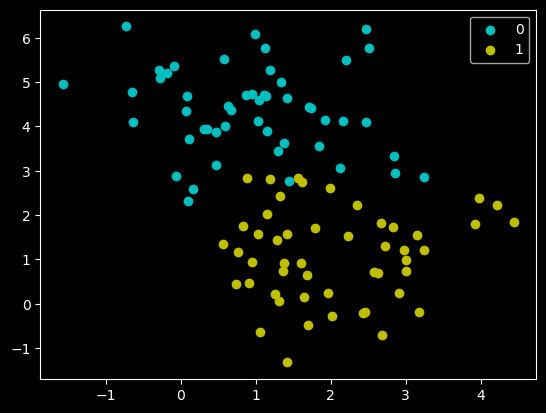

In [2]:
# Create the dataset
X, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=0)
y = y.reshape(-1, 1)

# Positive and negative data points
X_0 = X[np.where(y == 0)[0]]
X_1 = X[np.where(y == 1)[0]]

# Representation
plt.scatter(X_0[:, 0], X_0[:, 1], c="c", label=0)
plt.scatter(X_1[:, 0], X_1[:, 1], c="y", label=1)

plt.legend()
plt.grid(False)
plt.show()

In [3]:
X.shape, y.shape

((100, 2), (100, 1))

In [4]:
# Perceptron functions
def initialization(X):
    np.random.seed(0)
    W = np.random.randn(X.shape[1], 1)
    b = np.random.randn(1)
    return W, b

def model(X, W, b):
    Z = X.dot(W) + b
    A = 1 / (1 + np.exp(-Z))
    return A

def log_loss(A, y):
    epsilon = 1e-15
    return -1 / len(y) * np.sum(y * np.log(A + epsilon) + (1 - y) * np.log(1 - A + epsilon))

def gradients(A, X, y):
    dW = 1 / len(y) * X.T.dot(A - y)
    db = 1 / len(y) * np.sum(A - y)
    return dW, db

def update(dW, db, W, b, learning_rate):
    W = W - learning_rate * dW
    b = b - learning_rate * db
    return W, b

def predict(X, W, b):
    A = model(X, W, b)
    return A >= 0.5

In [5]:
def artificial_neuron(X, y, learning_rate=0.1, n_iter=100):
    # Initialization
    W, b = initialization(X)

    # Learning loop
    history = []
    loss = []
    for i in range(n_iter):
        A = model(X, W, b)
        loss.append(log_loss(A, y))
        dW, db = gradients(A, X, y)
        W, b = update(dW, db, W, b, learning_rate)
        history.append([W, b, loss, i])
    
    return history

In [6]:
# Perceptron training
history = artificial_neuron(X, y)

W = history[-1][0]
b = history[-1][1]

In [7]:
import plotly.graph_objects as go

In [8]:
# Sigmoïd and data points 3D-representation

## Data grid
X1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
X2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(X1, X2)

## Weighted sum and activation
Z = W[0] * xx1 + W[1] * xx2 + b
A = 1 / (1 + np.exp(-Z))

## Figure
marker = {
    "size": 5,
    "color": y.flatten(),
    "colorscale": "YlGn",
    "opacity": 0.8
}

margin = { "l": 0, "r": 0, "b": 0, "t": 0}

### Sigmoïd
fig = go.Figure(
    data=[
        go.Surface(
            x=xx1,
            y=xx2,
            z=A,
            colorscale="YlGn",
            opacity=0.7
        )
    ]
)

### Data points
fig.add_scatter3d(
    x=X[:, 0].flatten(),
    y=X[:, 1].flatten(),
    z=y.flatten(),
    mode="markers",
    marker=marker
)

fig.update_layout(template="plotly_dark", margin=margin)
fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

In [9]:
# Animate the training process
def animate(params):
    # Extract the weight, biais, loss and current iteration
    W = params[0]
    b = params[1]
    loss = params[2]
    i = params[3]

    # Clear the figure
    ax[0].clear() # decision boundary
    ax[1].clear() # sigmoid
    ax[2].clear() # loss function

    # Points size
    s = 300

    # Separating targets
    y_0 = np.where(y == 0)[0]
    y_1 = np.where(y == 1)[0]
    
    # Decision boundary
    X_0 = X[y_0]
    X_1 = X[y_1]
    
    ## Data points (depending on their target)
    ax[0].scatter(X_0[:, 0], X_0[:, 1], s=s, c="#008066", edgecolors="k", linewidths=3, label=0)
    ax[0].scatter(X_1[:, 0], X_1[:, 1], s=s, c="#FFFF66", edgecolors="k", linewidths=3, label=1)

    ## Decision line
    x1 = np.linspace(X[:, 0].min() - 0.15, X[:, 0].max() + 0.15, 100)
    x2 = -(W[0] * x1 + b) / W[1]
    ax[0].plot(x1, x2, c="orange", lw=4)

    ax[0].set_xlim(X[:, 0].min() - 0.15, X[:, 0].max() + 0.15)
    ax[0].set_title("Decision boundary")
    ax[0].set_xlabel("$x_1$")
    ax[0].set_ylabel("$x_2$")

    ax[0].legend()
    ax[0].grid(False)

    # Sigmoid
    ## Activate a range of weighted sums to draw the sigmoid
    z = X.dot(W) + b
    z_new = np.linspace(z.min(), z.max(), 100)
    A = 1 / (1 + np.exp(-z_new))
    
    ## Sigmoid and data points at top and bottom of the curve (label 1 and 0)
    ax[1].plot(z_new, A, c="orange", lw=4)
    ax[1].scatter(z[y_0], np.zeros(z[y_0].shape), c="#008066", edgecolors="k", linewidths=3, s=s)
    ax[1].scatter(z[y_1], np.ones(z[y_1].shape), c="#FFFF66", edgecolors="k", linewidths=3, s=s)

    ax[1].set_xlim(z.min(), z.max())
    ax[1].set_title("Sigmoid")
    ax[1].set_xlabel("Z")
    ax[1].set_ylabel("A(Z)")

    ## Difference between activation (probability) and groundtruth
    ### Class 0
    for j in range(len(A[y_0])):
        y_min = 0
        y_max = 1 / (1 + np.exp(-z[y_0][j]))
        ax[1].vlines(z[y_0][j], y_min, y_max, color="red", alpha=0.5, zorder=-1)
        
    ### Class 1
    for j in range(len(A[y_1])):
        y_min = 1 / (1 + np.exp(-z[y_1][j]))
        y_max = 1
        ax[1].vlines(z[y_1][j], y_min, y_max, color="red", alpha=0.5, zorder=-1)

    # Loss
    ax[2].plot(list(range(i)), loss[:i], color="r", lw=4)
    ax[2].set_xlim(0, len(loss))
    ax[2].set_ylim(0, loss[0] * 1.1)
    ax[2].set_title("Loss function")
    ax[2].set_xlabel("iteration")
    ax[2].set_ylabel("loss")

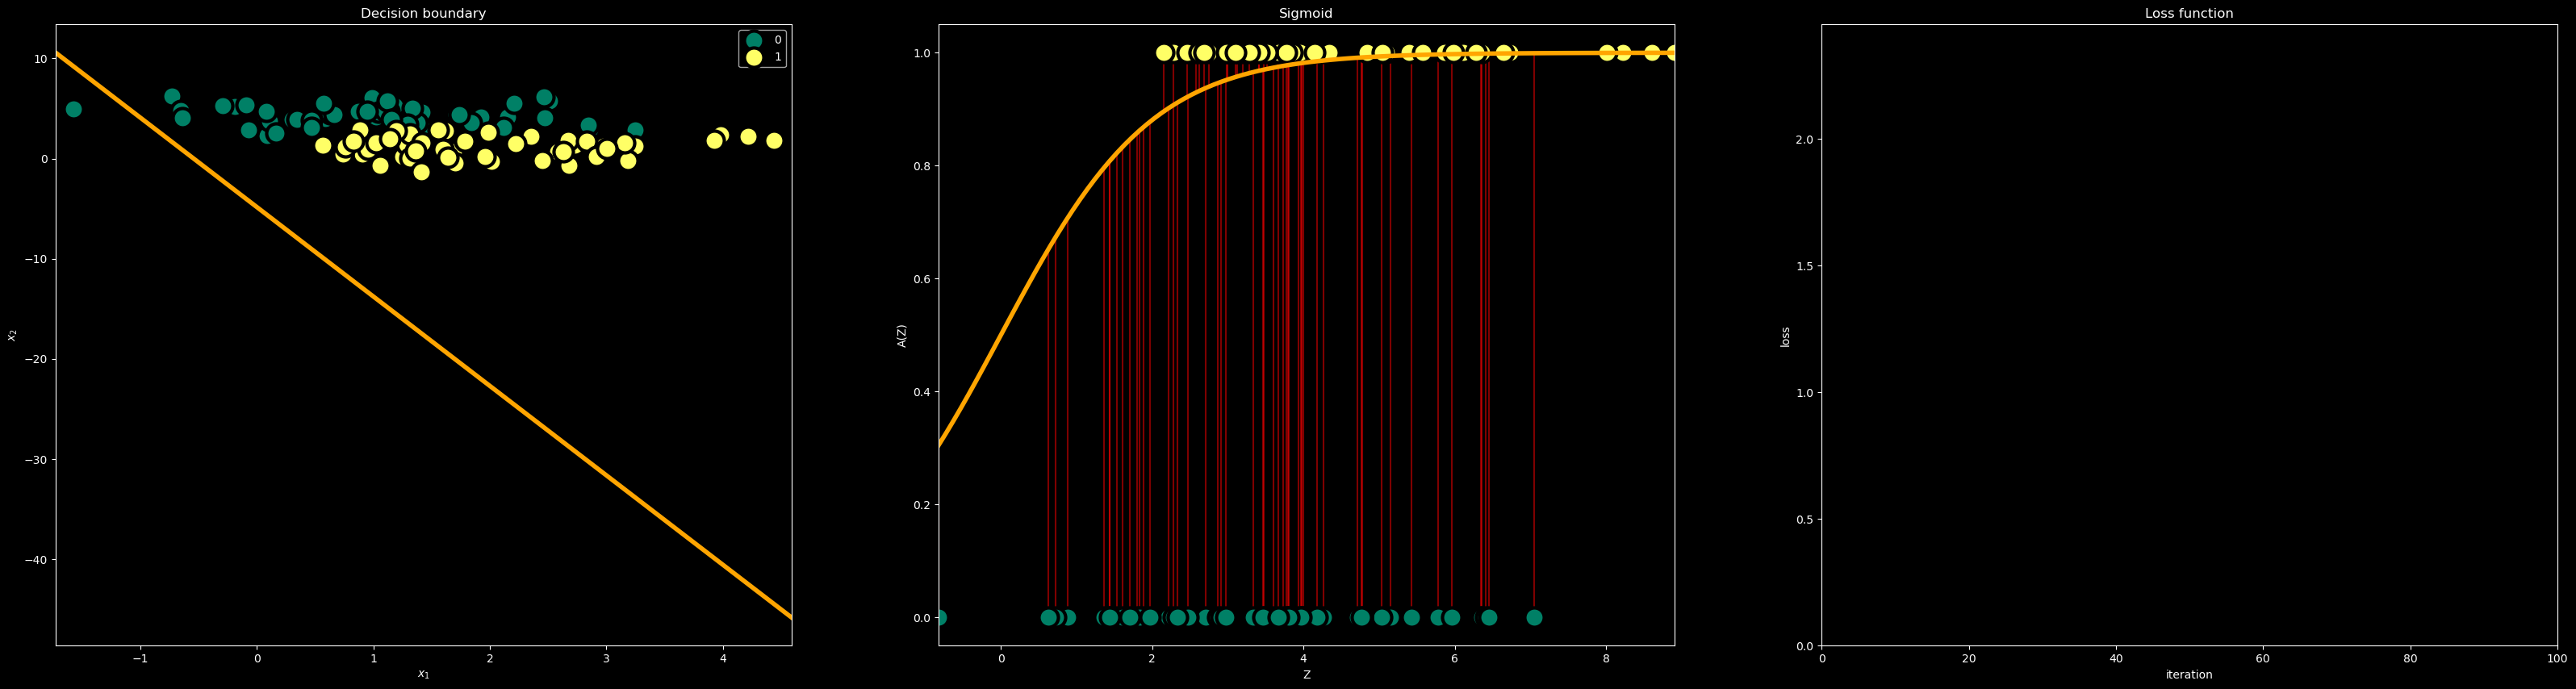

In [10]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 3, figsize=(40, 10))
ani = FuncAnimation(fig, animate, frames=history, interval=20, repeat=False)

import matplotlib.animation as animation
Writer = animation.writers["ffmpeg"]
metadata = {"artist": "Me"}
writer = Writer(fps=10, metadata=metadata, bitrate=3200)
ani.save("perceptron.mp4", writer=writer)

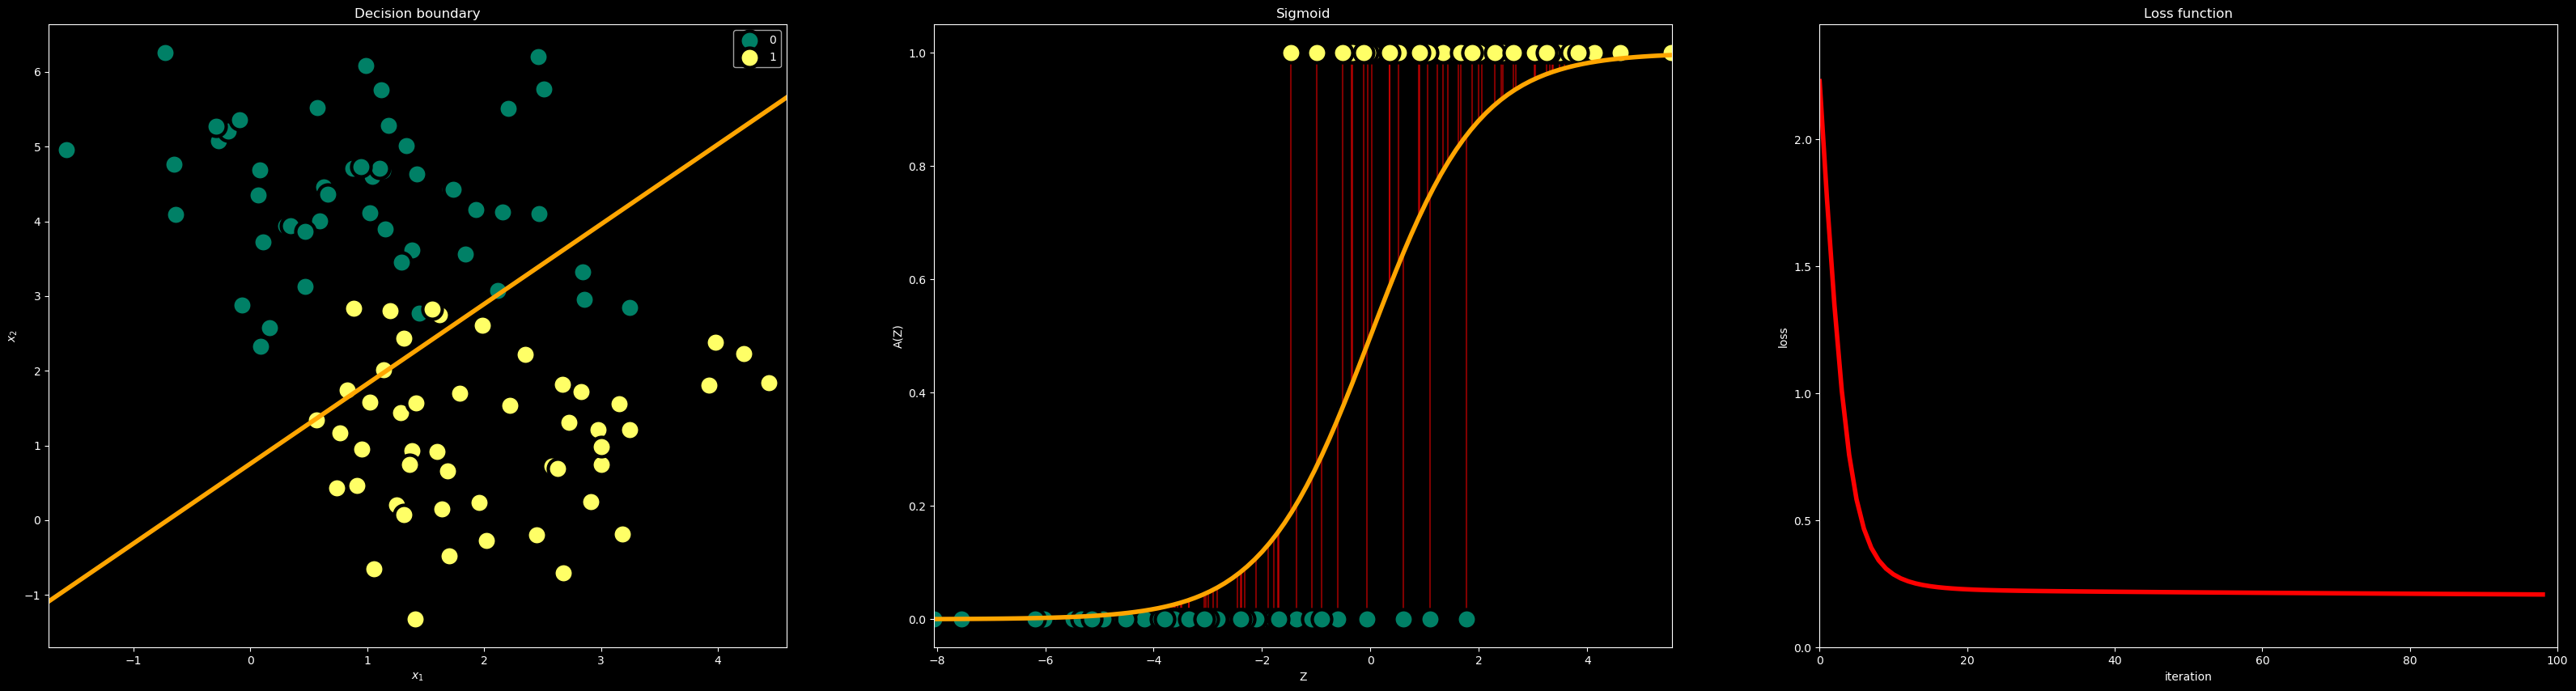

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(40, 10))
animate(history[99])